In [4]:
import numpy as np
from sklearn import svm,datasets
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
import scipy.optimize
import csv
from sklearn.model_selection import KFold
import cvxopt
import cvxopt.solvers
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
import random

float_formatter = lambda x : "%.5f" %x
np.set_printoptions(formatter =  {'float_kind' : float_formatter})

# Definitions for linear/polynomial/RBF kernels

In [5]:
def linear_kernel2(x,xp):
    return x.dot(xp.T)

def poly_kernel2(x, xp, alpha = 1, deg = 2) :
    return np.power(x.dot(xp.T) + alpha, deg)

def RBF_kernel2(x, xp, sigma = 1) :
    return np.exp(-(np.linalg.norm(x.T - xp.T, ord =2) ** 2)/ (2 * (sigma ** 2)))


# SVM Main Code

In [6]:
def mx(x):
    return cvxopt.matrix(x)

def simplesvm(inputval,outputval,targetset,ktype='linear',lambdaval=0,sigmaval=1,alphaval=1,poly_degree=2,cval=1):
    # Returns predicted class of targetset, and the x,y support vector

    ##############
    # CREATE MODEL
    ##############
    
    numdata, numdimension = inputval.shape
    
    # Calculate BigK
    for i in inputval:
        SubKResult = np.array([])
        for j in inputval:
            if ktype == 'poly':
                SubKResult = np.append(SubKResult,np.array([poly_kernel2(i,j,alphaval,poly_degree)]))
            elif ktype == 'linear':
                SubKResult = np.append(SubKResult,np.array([linear_kernel2(i,j)]))
            elif ktype == 'RBF':
                SubKResult = np.append(SubKResult,np.array([RBF_kernel2(i,j,sigmaval)]))
        if 'BigK' in locals():
            BigK = np.vstack([BigK,np.matrix(SubKResult)])
        else:
            BigK = np.array(SubKResult)
    BigK = np.array(BigK) # convert from matrix type to array type
    #print 'BigK :',BigK

    # Perform Quadratic Programming
    P = np.outer(outputval, outputval) * BigK
    q = np.negative(np.ones(numdata))
    G = np.vstack(((np.diag(np.negative(np.ones(numdata))),np.identity(numdata))))
    h = np.hstack((np.zeros(numdata), np.ones(numdata)*cval))
    cvxopt.solvers.options['show_progress'] = False
    QPResult = cvxopt.solvers.qp(mx(P),mx(q),mx(G),mx(h),cvxopt.matrix(outputval,(1,numdata)),mx(0.0))
    
    # calculate a
    a = np.ravel(QPResult['x'])
    #print 'a: ',a
    
    # Pick the support vector (val > pseudozero) -> because value is float
    pseudozero = 0.0000001
    sv_y = np.array([])
    sv_idx = a > pseudozero
    for idx,val in enumerate(a):
        if val>pseudozero:
            if 'sv_x' in locals():
                sv_x = np.vstack([sv_x,np.array([inputval[idx]])])
                sv_K = np.vstack([sv_K,np.array([BigK[idx,sv_idx]])])
            else:
                sv_x = np.array(inputval[idx])
                sv_K = np.array(BigK[idx,sv_idx])
            sv_y = np.append(sv_y,outputval[idx])
    #print sv_K
            
    # calculate b
    b = 0
    amod = a[a>pseudozero]
    #print 'amod ',a
    axy = amod * sv_y
    for (val_y,val_K) in zip(sv_y,sv_K):
        b += val_y - np.sum(axy * val_K)
    b = b/(sv_y.shape[0]) # don't forget to divide by N
    #print 'b: ',b
    
    # Model is done.
    ################
    
    
    # Predict class of target
    for i in targetset:
        result = 0        
        for x,y,z in zip(amod,sv_y,sv_x):
            if ktype == 'poly':
                kernelval = poly_kernel2(i,z,alphaval,poly_degree)
            elif ktype == 'linear':
                kernelval = linear_kernel2(i,z)
            elif ktype == 'RBF':
                kernelval = RBF_kernel2(i,z,sigmaval)
            result += x * y * kernelval
            #print 'x y kernelval result',x,y,kernelval, result
        #print 'i result',i,' ',result
        result += b
        if 'predictval' in locals():
            predictval = np.append(predictval,-1.0 if result<0 else 1.0)
        else:
            predictval = np.array([-1 if result<0 else 1])
    
    del (BigK)
    
    return predictval, sv_x, sv_y

# PROOF OF CORRECTNESS USING TRIVIAL DATA

Using  15  points for support
Correct:  40 / 40


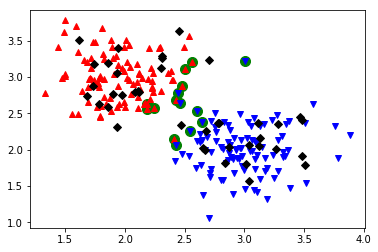

In [7]:
# Create two random class of data
# Which centers on (2,3) and (3,2) respectively

numdata = 100 # Nbr of datapoints for each class
centerplusone = [2,3] # center of the first class (y = +1)
centerminusone = [3,2] # center of the second class (y = -1)
variance = 0.1 # larger -> more scatter

# First Class
x1 = np.random.multivariate_normal(np.array(centerplusone),np.array([[variance,0],[0,variance]]),numdata)
y1 = np.ones(numdata) # y = +1

# Second Class
x2 = np.random.multivariate_normal(np.array(centerminusone),np.array([[variance,0],[0,variance]]),numdata)
y2 = np.negative(np.ones(numdata)) # y = -1

# Test data
xt1 = np.random.multivariate_normal(np.array(centerplusone),np.array([[variance,0],[0,variance]]),numdata/5)
xt2 = np.random.multivariate_normal(np.array(centerminusone),np.array([[variance,0],[0,variance]]),numdata/5)
xt = np.concatenate((xt1,xt2))
yt1 = np.ones(numdata/5)
yt2 = np.negative(np.ones(numdata/5))
yt = np.concatenate((yt1,yt2))

# Run SVM on Trivial Data
C = 3 # too large->overfit
x = np.concatenate((x1,x2)) # combine first and second class into one dataset
y = np.concatenate((y1,y2))
predict,svx,svy = simplesvm(x,y,xt,ktype='RBF',cval=C)
correct = np.sum(predict==yt)
print 'Using ',svy.shape[0],' points for support'
print 'Correct: ',correct,'/',yt.shape[0]
incorrect = xt[predict<>yt]

# Plot
plt.plot(x1[:,0], x1[:,1], "r^") # first class (+1) - red up triangle
plt.plot(x2[:,0], x2[:,1], "bv") # second class (-1) - blue down triangle
plt.plot(xt[:,0], xt[:,1], "kD", marker='D') # target - black diamond
plt.scatter(svx[:,0], svx[:,1], s=100, c="g", marker='o') # support vector - green circle
plt.scatter(incorrect[:,0], incorrect[:,1], s=100, c='m', marker='o') # incorrect - magenta circle
plt.show()

plt.clf()
plt.cla()
plt.close()

In [8]:
#regression call for kernelized ridge regression

def svm_reg(inputval,outputval,targetset,truthset,ktype,cvals=[]) :
    '''the following function will perform SVM regression with
       respective kernel and multiple value of C as defined'''
    allresult = []
    for c in cvals:
        predict,svx,svy = simplesvm(inputval,outputval,targetset,ktype=ktype,cval=c)
        pcterr = np.sum(predict<>yt)/truthset.shape[0]
        allresult.append([c, pcterr])
    return np.array(allresult)

# WORKING OF KERNELS ON RANDOMLY GENERATED IRIS DATASET
# 1. Divide testdata into Train / Validate(80%) and Test(20%)

In [9]:
# Load IRIS Data
iris = datasets.load_iris()
#print "Iris data set Description :: ", iris['DESCR']

# Use only the last two classes (row 50 - 150)
# Use only the last two features (feat. 2-3)
# Because data is sorted based on class, we choose row 50-90;100-140 as test/validate
# and 90-100;140-150 as test set
x3 = iris.data[50:100,2:]
x4 = iris.data[100:150,2:]
y3 = np.ones(50)
y4 = np.negative(np.ones(50))
x = np.concatenate([x3,x4])
y = np.concatenate([y3,y4])

# create train and test set
X_trainval,X_test,Y_trainval,Y_test=train_test_split(x,y,test_size=0.2,stratify=y)


# 2. Run Hyper Parameter regression to find the best parameters based on Pct error

# 2.a. Linear Kernel

In [10]:
# hyperparam
cvals = [0.01,0.1,1,10]

# Perform 5-fold cross validation on train/validate
kf = KFold(n_splits=5)

kf.get_n_splits(X_trainval)
print 'K-Fold (linear kernel)'

best_linear_err = None
kfoldstep = 0
for train_idx, validate_idx in kf.split(X_trainval):
    kfoldstep += 1
    print 'Fold: ',kfoldstep
    mlinput, mltest = X_trainval[train_idx], X_trainval[validate_idx]
    mloutput, testtruth = Y_trainval[train_idx], Y_trainval[validate_idx]
    
    # Linear Kernelized Ridge Regression
    result = svm_reg(mlinput,mloutput,mltest,testtruth,'linear',cvals=cvals)
    result = result[result[:, 1].argsort()] # sort based on error
    if (result[0,1] < best_linear_err) or (best_linear_err == None) :
        best_linear_err = result[0,1]
        best_linear_c = result[0,0]
    
print 'Best c for linear kernel is : ', best_linear_c
print '\nFinal linear kernel error against test set: ',best_linear_err

K-Fold (linear kernel)
Fold:  1
Fold:  2


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


Fold:  3
Fold:  4
Fold:  5
Best c for linear kernel is :  0.01

Final linear kernel error against test set:  0.0


# 2.b. Polynomial Kernel

In [11]:
# hyperparam
cvals = [0.01,0.1,1,10]

# Perform 5-fold cross validation on train/validate
kf = KFold(n_splits=5)

kf.get_n_splits(X_trainval)
print 'K-Fold (polynomial kernel)'

best_poly_err = None
kfoldstep = 0
for train_idx, validate_idx in kf.split(X_trainval):
    kfoldstep += 1
    print 'Fold: ',kfoldstep
    mlinput, mltest = X_trainval[train_idx], X_trainval[validate_idx]
    mloutput, testtruth = Y_trainval[train_idx], Y_trainval[validate_idx]
    
    # Linear Kernelized Ridge Regression
    result = svm_reg(mlinput,mloutput,mltest,testtruth,'poly',cvals=cvals)
    result = result[result[:, 1].argsort()] # sort based on error
    if (result[0,1] < best_poly_err) or (best_poly_err == None) :
        best_poly_err = result[0,1]
        best_poly_c = result[0,0]
    
print 'Best c for polynomial kernel is : ', best_poly_c
print '\nFinal polynomial kernel error against test set: ',best_poly_err

K-Fold (polynomial kernel)
Fold:  1


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


Fold:  2
Fold:  3
Fold:  4
Fold:  5
Best c for polynomial kernel is :  0.01

Final polynomial kernel error against test set:  0.0


# 2.c. RBF Kernel

In [12]:
# hyperparam
cvals = [0.01,0.1,1,10]

# Perform 5-fold cross validation on train/validate
kf = KFold(n_splits=5)

kf.get_n_splits(X_trainval)
print 'K-Fold (RBF kernel)'

best_rbf_err = None
kfoldstep = 0
for train_idx, validate_idx in kf.split(X_trainval):
    kfoldstep += 1
    print 'Fold: ',kfoldstep
    mlinput, mltest = X_trainval[train_idx], X_trainval[validate_idx]
    mloutput, testtruth = Y_trainval[train_idx], Y_trainval[validate_idx]
    
    # Linear Kernelized Ridge Regression
    result = svm_reg(mlinput,mloutput,mltest,testtruth,'RBF',cvals=cvals)
    result = result[result[:, 1].argsort()] # sort based on error
    if (result[0,1] < best_rbf_err) or (best_rbf_err == None) :
        best_rbf_err = result[0,1]
        best_rbf_c = result[0,0]
    
print 'Best c for rbf kernel is : ', best_poly_c
print '\nFinal rbf kernel error against test set: ',best_rbf_err

K-Fold (RBF kernel)
Fold:  1


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


Fold:  2
Fold:  3
Fold:  4
Fold:  5
Best c for rbf kernel is :  0.01

Final rbf kernel error against test set:  0.0


# 3. Use best parameter and kernel against test data and plot it

Using  80  points for support
Correct:  19 / 20


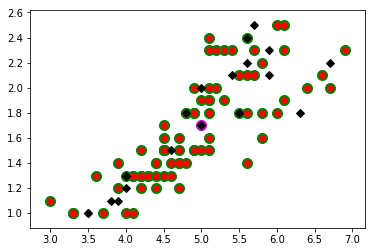

In [13]:
# All kernels are equally good at classifying
# We'll just pick RBF
X_trainval,X_test,Y_trainval,Y_test=train_test_split(x,y,test_size=0.2,stratify=y)

predict,svx,svy = simplesvm(X_trainval,Y_trainval,X_test,ktype='linear',cval=0.01)
correct = np.sum(predict==Y_test)
print 'Using ',svy.shape[0],' points for support'
print 'Correct: ',correct,'/',Y_test.shape[0]
incorrect = X_test[predict<>Y_test]

plt.plot(X_trainval[:,0], X_trainval[:,1], "ro") # training data - red dot
plt.plot(X_test[:,0], X_test[:,1], "kD") # test set - black diamond
plt.scatter(svx[:,0], svx[:,1], s=100, c="g", marker='o') # support vector - green circle
plt.scatter(incorrect[:,0], incorrect[:,1], s=100, c='m', marker='o') # incorrect - magenta circle
plt.show()

plt.clf()
plt.cla()
plt.close()

#print x_test
#print y_test

# 4. Implemenetation of sklearn API SVC on iris dataset

In [14]:
iris = datasets.load_iris()
print "Iris data set Description :: ", iris['DESCR']

Iris data set Description ::  Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Mis

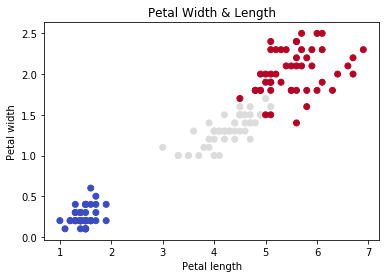

In [28]:
def visuvalize_petal():
    iris = datasets.load_iris()
    X = iris.data[:, 2:]  # we only take the last two features.
    y = iris.target
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Petal length')
    plt.ylabel('Petal width')
    plt.title('Petal Width & Length')
    plt.show()
 
visuvalize_petal()

The petal dataset gets more accurate results as compared to the 

In [29]:
iris = datasets.load_iris()
X = iris.data[:, 2:]
y = iris.target
C = 1.0  # SVM regularization parameter

# SVC with linear kernel
lin_svc = svm.SVC(kernel='linear', C=C).fit(X, y)
# SVC with RBF kernel
rbf_svc = svm.SVC(kernel='rbf', gamma=0.001, C=C).fit(X, y)
# SVC with polynomial (degree 3) kernel
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)

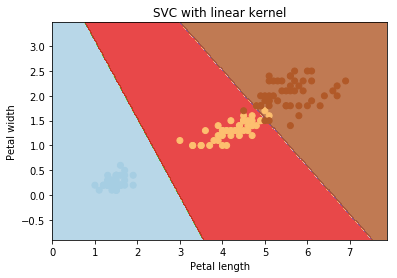

In [30]:
x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
h = .02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
plt.subplot(1,1,1)
Z = lin_svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap = plt.cm.Paired, alpha = 0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.xlim(xx.min(), xx.max())
plt.title('SVC with linear kernel')
plt.show()

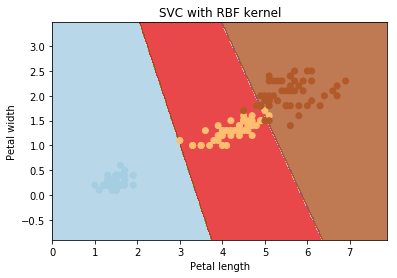

In [31]:
x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
h = .02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
plt.subplot(1,1,1)
Z = rbf_svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap = plt.cm.Paired, alpha = 0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.xlim(xx.min(), xx.max())
plt.title('SVC with RBF kernel')
plt.show()

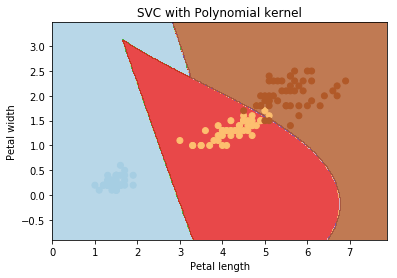

In [32]:
x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
h = .02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
plt.subplot(1,1,1)
Z = poly_svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap = plt.cm.Paired, alpha = 0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.xlim(xx.min(), xx.max())
plt.title('SVC with Polynomial kernel')
plt.show()

# Performance of sckit-learn API

In [33]:
model= svm.SVC()
model.fit(x_train,y_train.ravel())
y_pred=model.predict(x_test)
print model.score(x_test,y_test.ravel())

1.0


In [34]:
param={'coef0':[1e0,0.1,1e-2,1e-3,0.5,2,3,5]}

grid_l = GridSearchCV(svm.SVC(kernel = 'linear'), param, cv = 5)
grid_l.fit(x_train, y_train)
print grid_l.best_score_
print grid_l.best_params_
#model.get_params().keys()
#model_linear = svm.SVC(kernel = 'linear', coef0 = 1.0, C = 5)
#model_linear.fit(x_train,y_train)
y_target1 = grid_l.predict(x_test)
score = metrics.r2_score(y_test, y_target1)
print score 

0.961904761905
{'coef0': 1.0}
1.0


In [35]:
grid_poly= GridSearchCV(svm.SVC(kernel='poly', degree = 3), cv=5, param_grid={"coef0":[1e0,0.1,1e-2,1e-3,0.5,2,3,5], "gamma":[0.001,0.0001,0.01,0.1,1,0.5,2,3]})
grid_poly.fit(x_train,y_train)
print grid_poly.best_score_
print grid_poly.best_params_
#model_poly = svm.SVC(kernel = 'poly', degree = 2, coef0 = 5, gamma = 0.1, C = 5)
#model_poly.fit(x_train,y_train)
y_target2 = grid_poly.predict(x_test)
score_poly = metrics.r2_score(y_test, y_target2)
print score_poly 

0.961904761905
{'coef0': 3, 'gamma': 0.01}
1.0


In [36]:
grid_gaussian= GridSearchCV(svm.SVC(kernel="rbf"), cv=5, param_grid={"coef0":[1e0,0.1,1e-2,1e-3,0.5,2,3,5], "gamma":[0.001,0.0001,0.01,0.1,1,0.5,2,3,10]})
grid_gaussian.fit(x_train,y_train)
print grid_gaussian.best_score_
print grid_gaussian.best_params_
y_target3=grid_gaussian.predict(x_test)
score_gauss = metrics.r2_score(y_test, y_target3)
print score_gauss 

0.952380952381
{'coef0': 1.0, 'gamma': 0.1}
1.0
